In [3]:
# Setup

# common:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# import eli5 # Feature importance evaluation



# set some display options:
sns.set(style="whitegrid")
pd.set_option("display.max_columns", 36)

# load data:
file_path = "hotel_bookings.csv"
full_data = pd.read_csv(file_path)

In [4]:
full_data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [3]:
full_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
full_data['country']

0         PRT
1         PRT
2         GBR
3         GBR
4         GBR
         ... 
119385    BEL
119386    FRA
119387    DEU
119388    GBR
119389    DEU
Name: country, Length: 119390, dtype: object

In [6]:
nan_replacement={"children":0.0, "country":"unknown","agent":0, "company":0}
full_data_cln= full_data.fillna(nan_replacement)

full_data_cln["meal"].replace("Undifined","SC", inplace=True)

#The list which has no guest
zero_guest= list(full_data_cln.loc[full_data_cln["adults"]+
                                full_data_cln["children"]+
                                full_data_cln["babies"] == 0].index)
full_data_cln.drop(full_data_cln.index[zero_guest], inplace=True)

In [7]:
full_data_cln["country"].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'unknown', 'ROU', 'NOR',
       'OMN', 'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA',
       'NLD', 'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN',
       'MOZ', 'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR',
       'UKR', 'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU',
       'TUR', 'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN',
       'GEO', 'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY',
       'KWT', 'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN',
       'LBN', 'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM',
       'MKD', 'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS',
       'COM', 'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI',
       'SAU', 'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU',
       'MDG', 'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI',
       'STP', 'KN

In [8]:
full_data_cln.loc[full_data_cln["is_canceled"]==0]["country"].value_counts()

country
PRT    20977
GBR     9668
FRA     8468
ESP     6383
DEU     6067
       ...  
BHR        1
DJI        1
MLI        1
NPL        1
FRO        1
Name: count, Length: 166, dtype: int64

## Where do the guest came from

In [9]:
full_data_cln.loc[full_data_cln["is_canceled"]==0]["country"].value_counts()

country
PRT    20977
GBR     9668
FRA     8468
ESP     6383
DEU     6067
       ...  
BHR        1
DJI        1
MLI        1
NPL        1
FRO        1
Name: count, Length: 166, dtype: int64

In [10]:
country_data=pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"]==0]["country"].value_counts())
country_data.rename(columns={"country":"no_of_guest"}, inplace=True)

total_guest= country_data["no_of_guest"].sum()
country_data["Guest in %"] = round(country_data["no_of_guest"]/total_guest * 100,2)
country_data["country"] = country_data.index

country_data.head()

KeyError: 'no_of_guest'

In [12]:
# pie plot
fig = px.pie(country_data,
             values="no_of_guest",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

ValueError: Value of 'names' is not the name of a column in 'data_frame'. Expected one of ['count'] but received: country

In [11]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data.index,
                    color=country_data["Guest in %"], 
                    hover_name=country_data.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

KeyError: 'Guest in %'

### The number of hotel which aren't canceled

In [11]:
ch= full_data_cln.loc[(full_data_cln["hotel"] == "City Hotel") & (full_data_cln["is_canceled"] == 0)]
rh = full_data_cln.loc[(full_data_cln["hotel"] == "Resort Hotel") & (full_data_cln["is_canceled"] == 0)]

In [12]:
ch["adr"]

40060       0.00
40066      58.67
40070      86.00
40071      43.00
40072      86.00
           ...  
119385     96.14
119386    225.43
119387    157.71
119388    104.40
119389    151.20
Name: adr, Length: 46084, dtype: float64

In [13]:
ch["adr_pp"] = ch["adr"] / (ch["adults"] + ch["children"])
rh["adr_pp"] = rh["adr"] / (rh["adults"] + rh["children"])
print(round(rh["adr_pp"].mean(),2))
print(ch["adr_pp"].mean())

47.49
59.27298771446344


C:\Users\HP\AppData\Local\Temp\ipykernel_1692\304911273.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Temp\ipykernel_1692\304911273.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



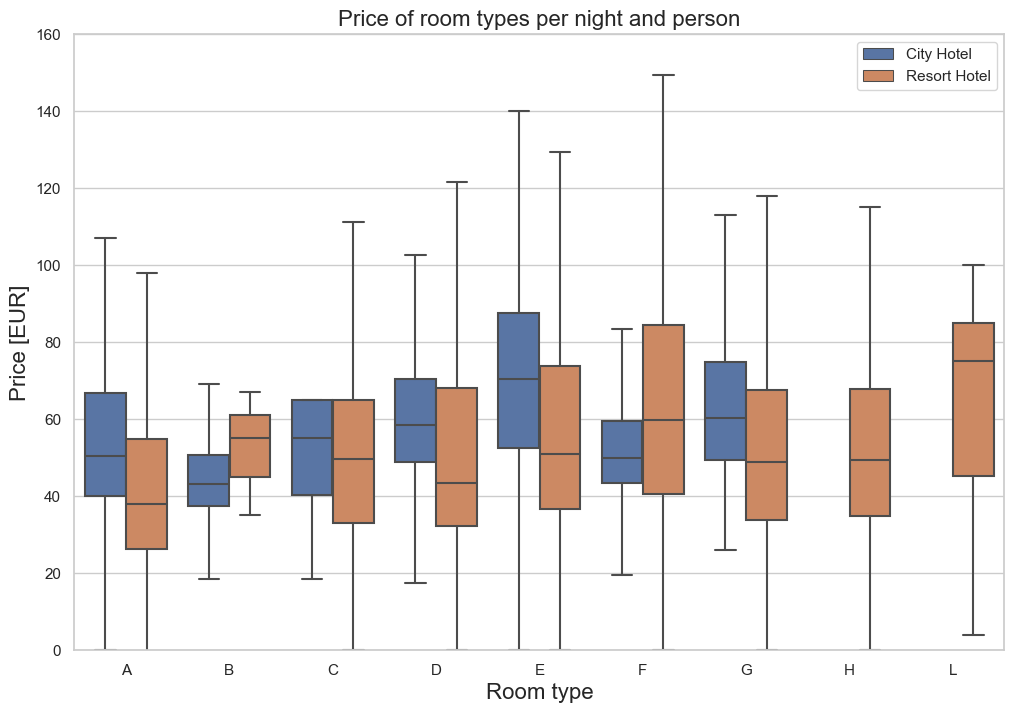

In [14]:
full_data_cln["adr_pp"] = full_data_cln["adr"] / (full_data_cln["adults"] + full_data_cln["children"])
guest_stay = full_data_cln.loc[full_data_cln["is_canceled"] == 0]
room_prices = full_data_cln[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="adr_pp",
            hue="hotel",
            data=room_prices, 
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

### Price vary per year

In [15]:
# grab data:
room_prices_mothly = guest_stay[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"],
                                                          categories=ordered_months, ordered=True)
room_prices_mothly.head()

,hotel,arrival_date_month,adr_pp
48869,City Hotel,April,81.90
110755,City Hotel,April,115.00
110756,City Hotel,April,57.50
110757,City Hotel,April,65.25
110758,City Hotel,April,65.25


C:\Users\HP\AppData\Local\Temp\ipykernel_1692\2260758639.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




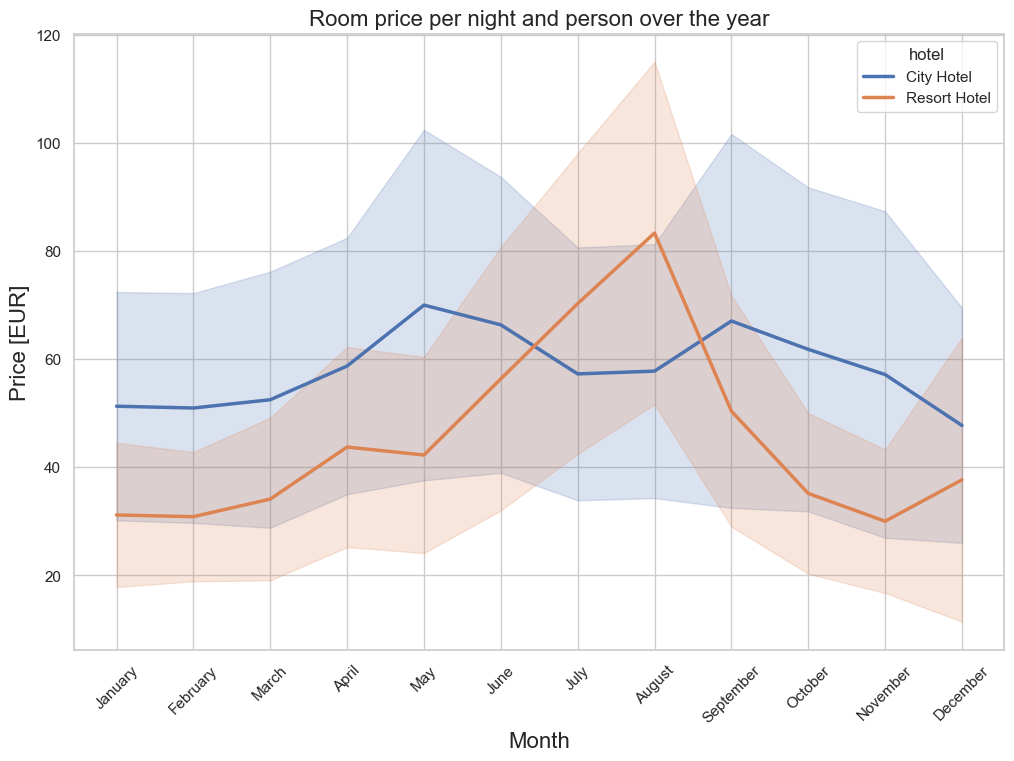

In [16]:
# barplot with standard deviation:
plt.figure(figsize=(12, 8))
sns.lineplot(x = "arrival_date_month", y="adr_pp", hue="hotel", data=room_prices_mothly, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()

### Which is the most busy month

In [17]:
# b_ch = 
room_prices_mothly.sort_values(by="arrival_date_month").head()

,hotel,arrival_date_month,adr_pp
83298,City Hotel,January,80.00
80852,City Hotel,January,76.00
80038,City Hotel,January,67.22
80037,City Hotel,January,41.95
80036,City Hotel,January,77.50


In [18]:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
resort_guests_monthly.values

array([2550, 3257, 2014, 2308, 1866, 3137, 2037, 2571, 2535, 1975, 2575,
       2102], dtype=int64)

In [19]:
# Create a DateFrame with the relevant data:
resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})
full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

# order by month:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

# Dataset contains July and August date from 3 years, the other month from 2 years. Normalize data:
full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3
full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

full_guest_data.head()

,month,hotel,guests
0,April,Resort hotel,1275.000000
1,August,Resort hotel,1085.666667
2,December,Resort hotel,1007.000000
3,February,Resort hotel,1154.000000
4,January,Resort hotel,933.000000


<!-- rgm = rh.groupby("arrival_date_month")["hotel"].count()
cgm = ch.groupby("arrival_date_month")["hotel"].count()

rgd = pd.DataFrame({"month":list(rgm.index),
                   "hotel":"Resort Hotel",
                   "guest":list(rgm.values)})
cgd = pd.DataFrame({"month":list(cgm.index),
                   "hotel":"City Hotel",
                   "guest":list(cgm.values)})
new_bm = pd.concat([rgd, cgd], ignore_index=True)

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
new_bm["month"] = pd.Categorical(new_bm["month"], categories=ordered_months, ordered=True) -->

In [20]:
rh.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_pp'],
      dtype='object')

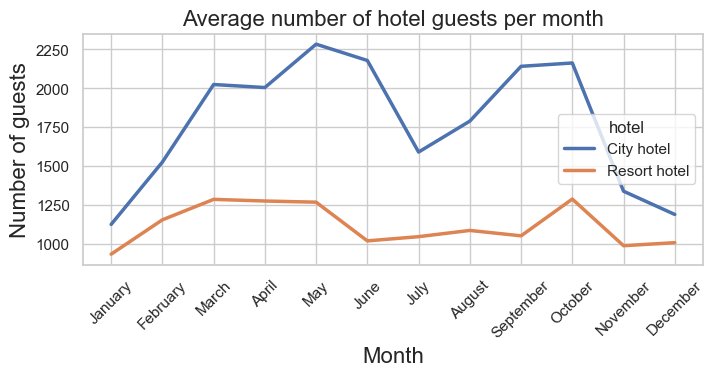

In [21]:
#show figure:
plt.figure(figsize=(8, 3))
sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))
plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

### How long people stay at this hotel

In [22]:
full_data_cln.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,49.0


In [23]:
full_data_cln["stays_in_week_nights"].unique()

array([ 0,  1,  2,  3,  4,  5, 10, 11,  8,  6,  7, 15,  9, 12, 33, 20, 14,
       16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 18, 34],
      dtype=int64)

In [24]:
ch

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
40060,City Hotel,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6.0,0.0,0,Transient,0.00,0,0,Check-Out,2015-07-03,0.000000
40066,City Hotel,0,3,2015,July,27,2,0,3,1,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,0.0,0,Transient-Party,58.67,0,0,Check-Out,2015-07-05,58.670000
40070,City Hotel,0,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,0.0,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05,43.000000
40071,City Hotel,0,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,0.0,0,Transient-Party,43.00,0,0,Check-Out,2015-07-05,21.500000
40072,City Hotel,0,43,2015,July,27,3,0,2,2,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1.0,0.0,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05,43.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,Check-Out,2017-09-06,48.070000
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,Check-Out,2017-09-07,75.143333
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,Check-Out,2017-09-07,78.855000
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,Check-Out,2017-09-07,52.200000


In [25]:
ch["total_stays"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]
rh["total_stays"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]

num_nights_res = list(rh["total_stays"].value_counts().index)
rel_nights_res = list(rh["total_stays"].value_counts())
per_nights_res = rh["total_stays"].value_counts() / sum(rel_nights_res) * 100

num_nights_city = list(ch["total_stays"].value_counts().index)
rel_nights_city = list(ch["total_stays"].value_counts())
per_nights_city = ch["total_stays"].value_counts() / sum(rel_nights_city) * 100

night_stay_res = pd.DataFrame({"hotel":"Resort Hotel",
                              "num_night":num_nights_res,
                              "per_night_bookings":per_nights_res})

night_stay_city = pd.DataFrame({"hotel":"City Hotel",
                              "num_night":num_nights_city,
                              "per_night_bookings":per_nights_city})

total_night_stay = pd.concat([night_stay_res, night_stay_city], ignore_index=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_13368\3080381339.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP\AppData\Local\Temp\ipykernel_13368\3080381339.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



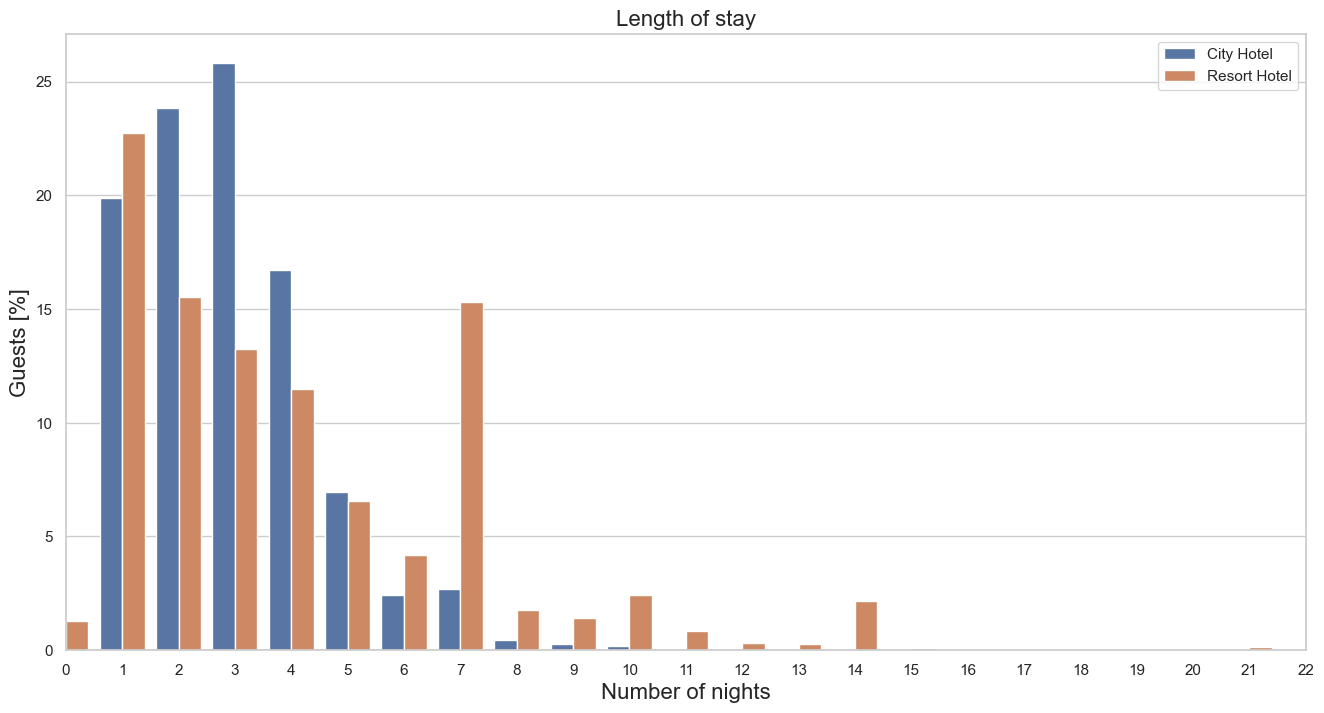

In [26]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_night", y = "per_night_bookings", hue="hotel", data=total_night_stay,
            hue_order = ["City Hotel", "Resort Hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [27]:
full_data_cln.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,adr_pp
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.00
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0.00
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.00
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,75.00
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,49.00
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,49.00
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,0.0,0.0,0,Transient,107.0,0,0,Check-Out,2015-07-03,53.50
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,0.0,0,Transient,103.0,0,1,Check-Out,2015-07-03,51.50
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,82.0,0,1,Canceled,2015-05-06,41.00
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,0.0,0,Transient,105.5,0,0,Canceled,2015-04-22,52.75


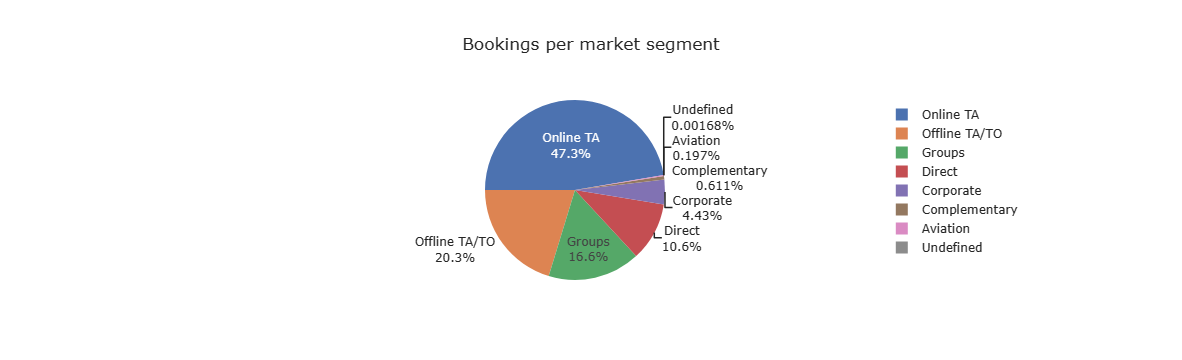

In [28]:
segments=full_data_cln["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

### price per night (ADR) and person based on booking and room.


C:\Users\HP\AppData\Local\Temp\ipykernel_13368\1956303125.py:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




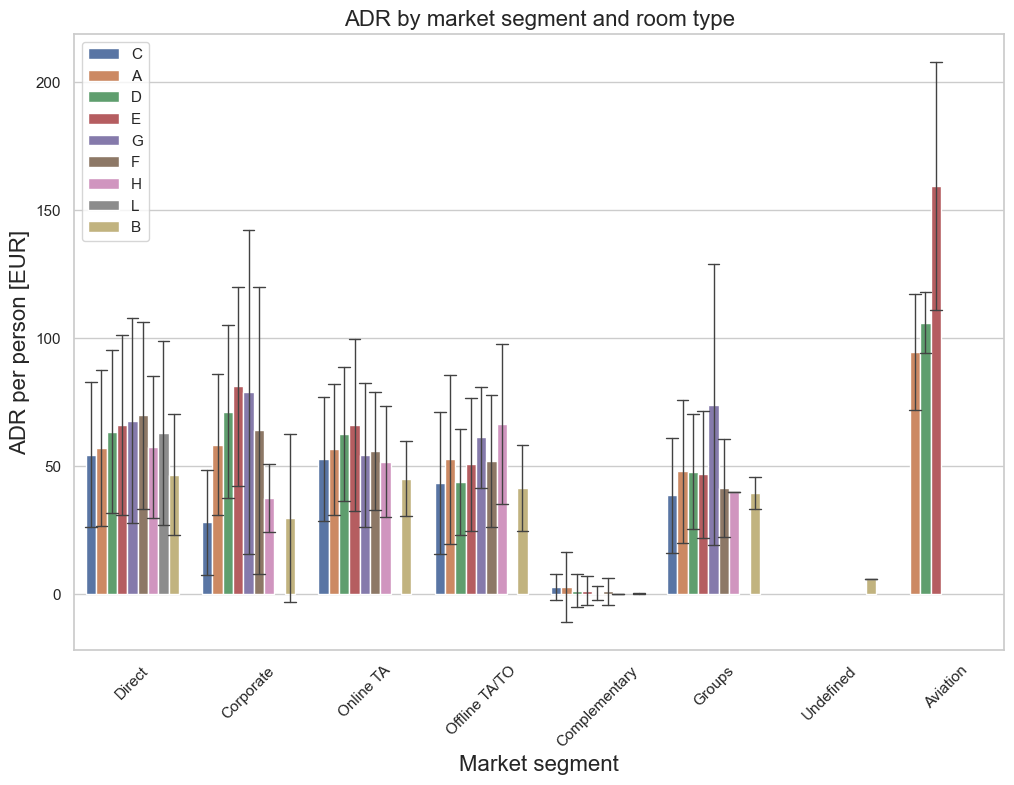

In [29]:

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=full_data_cln,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

##### full_data_cln["days_in_waiting_list"].unique()

In [30]:
full_data_cln.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'adr_pp'],
      dtype='object')

###### list(full_data_cln['market_segment'].unique())

### How many booking are canceled?

In [31]:
total_cancel_data = full_data_cln.loc[full_data_cln['is_canceled'] == 1]

# rh_cancel = 
(total_cancel_data["hotel"] == "Resort hotel").value_counts()

False    44199
Name: hotel, dtype: int64

In [32]:
full_data_cln['is_canceled']

0         0
1         0
2         0
3         0
4         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: is_canceled, Length: 119210, dtype: int64

### Which month have highest number of cancelation

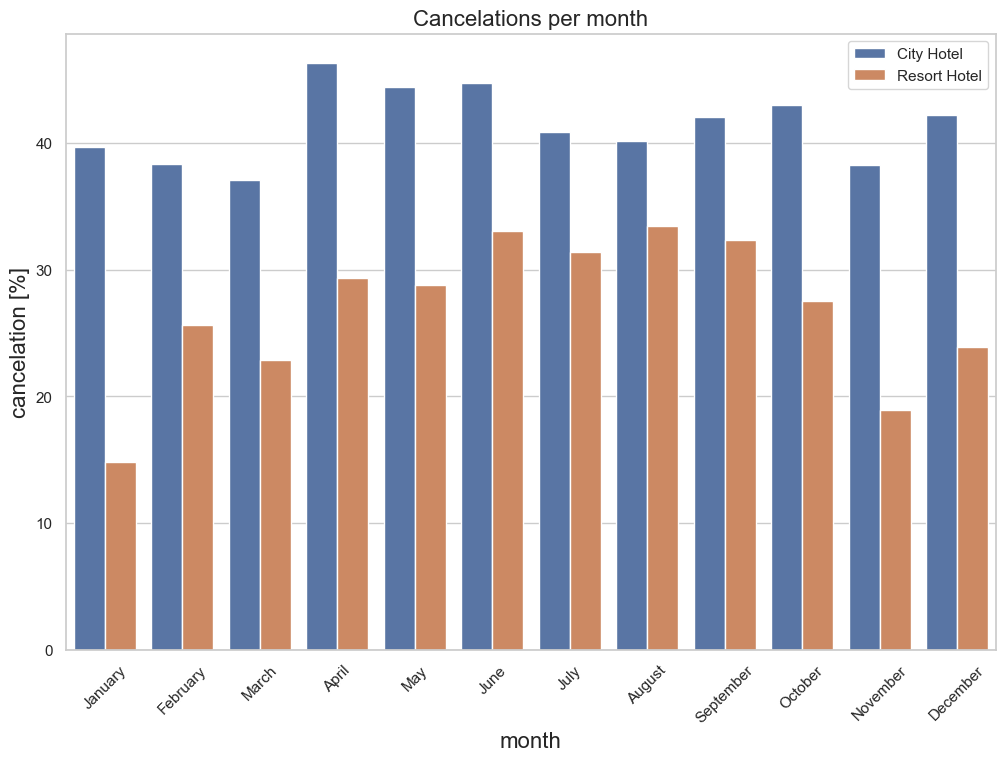

In [33]:
# # grab data:
# room_prices_mothly = guest_stay[["hotel", "arrival_date_month", "adr_pp"]].sort_values("arrival_date_month")

# # order by month:
# ordered_months = ["January", "February", "March", "April", "May", "June", 
#           "July", "August", "September", "October", "November", "December"]
# room_prices_mothly["arrival_date_month"] = pd.Categorical(room_prices_mothly["arrival_date_month"],
#                                                           categories=ordered_months, ordered=True)
# room_prices_mothly.head()

# pd.DataFrame(full_data_cln.loc[full_data_cln["is_canceled"]==1]["arrival_date_month"].value_counts())
rh_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"]=="Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()
rh_booking_per_month = full_data_cln.loc[(full_data_cln["hotel"]=="Resort Hotel")].groupby("arrival_date_month")["hotel"].count()

ch_cancel_per_month = full_data_cln.loc[(full_data_cln["hotel"]=="City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()
ch_booking_per_month = full_data_cln.loc[(full_data_cln["hotel"]=="City Hotel")].groupby("arrival_date_month")["hotel"].count()

rh_cancel_data = pd.DataFrame({"hotel":"Resort Hotel",
                               "month":list(rh_booking_per_month.index),
                              "booking":list(rh_booking_per_month.values),
                              "cancelation":list(rh_cancel_per_month.values)})

ch_cancel_data = pd.DataFrame({"hotel":"City Hotel",
                               "month":list(ch_booking_per_month.index),
                              "booking":list(ch_booking_per_month.values),
                              "cancelation":list(ch_cancel_per_month.values)})

total_cancel_data = pd.concat([rh_cancel_data,ch_cancel_data], ignore_index=True)
total_cancel_data["cancel percent"] = round((total_cancel_data["cancelation"] / total_cancel_data["booking"]) * 100, 2)

# Order by month
ordered_months = ["January", "February", "March", "April", "May", "June", 
                  "July", "August", "September", "October", "November", "December"]
total_cancel_data["month"] = pd.Categorical(total_cancel_data["month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "month", y = "cancel percent" , hue="hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=total_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("cancelation [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()


## 2. Predict cancelations

Which numerical features are most important?

In [34]:
cancel_corr = full_data.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

C:\Users\HP\AppData\Local\Temp\ipykernel_15844\446264670.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features.
However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.
I will also not include days_in_waiting_list and arrival_date_year.

The most important feature to exclude is the "reservation_status":

In [35]:
full_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

### Comparing different base models:

In [36]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country,
# days_in_waiting_list)
# including the country would increase accuracy, but it may also make the model less general

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = full_data.drop(["is_canceled"], axis=1)[features]
y = full_data["is_canceled"]

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [37]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    
    #pipeline.fit(X_train, y_train)
    #preds = pipeline.predict(X_valid)
    #score = accuracy_score(y_valid, preds)
    #print(f"{name} accuracy_score: {round(score, 4)}")

DT_model cross validation accuarcy score: 0.8246 +/- 0.0016 (std) min: 0.8221, max: 0.8263
RF_model cross validation accuarcy score: 0.8664 +/- 0.0012 (std) min: 0.8646, max: 0.8676
LR_model cross validation accuarcy score: 0.7936 +/- 0.0011 (std) min: 0.7921, max: 0.795
XGB_model cross validation accuarcy score: 0.8473 +/- 0.0011 (std) min: 0.8456, max: 0.8487


The RandomForst model performs best.
I also did some hyperparameter optimization, but the accuracy increase is minimal:

In [38]:
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.8681 +/- 0.0006 (std) min: 0.8673, max: 0.869


## 3. Evaluate Feature importance

In [39]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)
'''cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]'''
# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


#### Looking at the three most important features:
#####        lead_time
#####       deposit_type
#####        adr

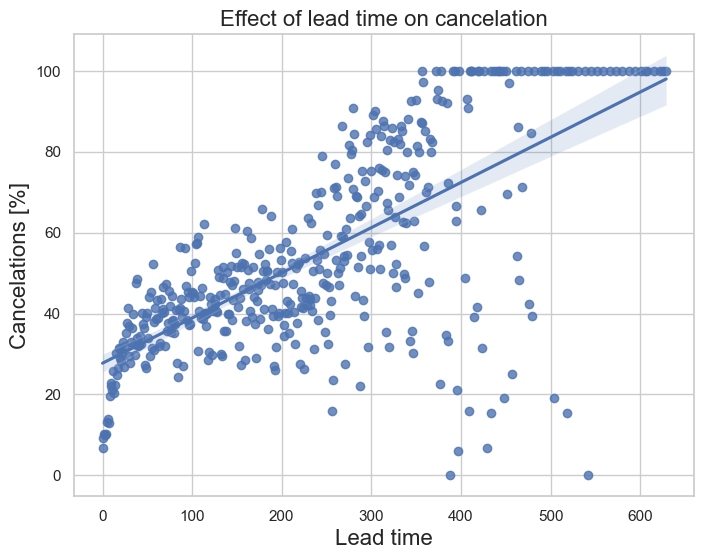

In [40]:
# group data for lead_time:
lead_cancel_data = full_data_cln.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

#show figure:
plt.figure(figsize=(8, 6))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

In [41]:
full_data_cln.groupby("lead_time")["is_canceled"].describe()

,count,mean,std,min,25%,50%,75%,max
lead_time,,,,,,,,
0,6264.0,0.066571,0.249297,0.0,0.0,0.0,0.0,1.0
1,3445.0,0.092308,0.289502,0.0,0.0,0.0,0.0,1.0
2,2065.0,0.103148,0.304225,0.0,0.0,0.0,0.0,1.0
3,1815.0,0.100275,0.300450,0.0,0.0,0.0,0.0,1.0
4,1710.0,0.102339,0.303182,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
622,17.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
626,30.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
629,17.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


Bookings made a few days before the arrival date are rarely canceled, whereas bookings made over one year in advance are canceled very often.

### Deposit type:

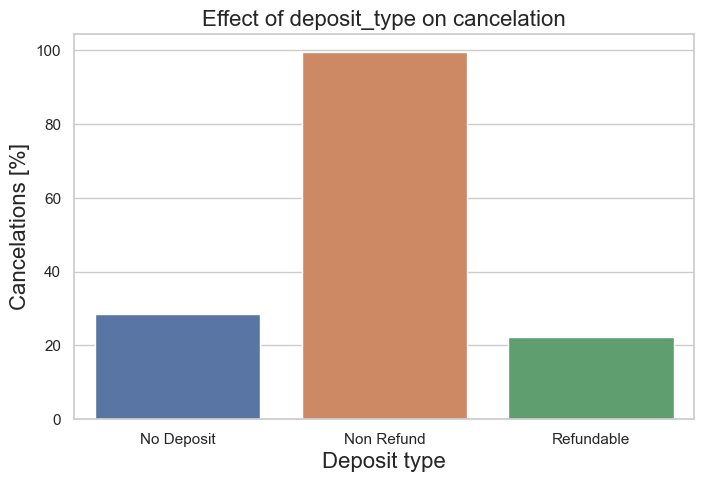

In [42]:
# group data for deposit_type:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()

#show figure:
plt.figure(figsize=(8, 5))
sns.barplot(x=deposit_cancel_data.index, y=deposit_cancel_data["mean"] * 100)
plt.title("Effect of deposit_type on cancelation", fontsize=16)
plt.xlabel("Deposit type", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

In [43]:
deposit_mean_data = full_data_cln.groupby("deposit_type").mean()
deposit_mean_data

C:\Users\HP\AppData\Local\Temp\ipykernel_15844\3157876600.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,adr_pp
deposit_type,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.284020,88.841951,2016.173950,27.133208,15.815223,0.969615,2.555633,1.865806,0.118599,0.009085,0.035295,0.042044,0.154938,0.247030,78.745503,11.175874,1.518040,103.685436,0.071184,0.651726,55.231806
Non Refund,0.993624,212.908891,2016.031466,27.448619,15.595462,0.621718,2.091109,1.811407,0.000617,0.000000,0.004387,0.411462,0.010626,0.012477,47.480016,6.215809,7.992253,89.964017,0.000069,0.001782,54.520286
Refundable,0.222222,152.098765,2016.141975,20.932099,23.456790,0.975309,2.851852,1.907407,0.030864,0.000000,0.024691,0.000000,0.018519,0.592593,56.185185,133.666667,9.586420,76.209753,0.123457,0.141975,41.444239


Comparing the mean values for Non refund to No Deposit shows the following:
- Non Refund deposits are characterized by > 2x longer lead_time   
- is_repeated_guest is ~ 1/10th  
- previous_cancellations is 10x higher 
- previous_bookings_not_canceled is 1/15th  
- required_car_parking_spaces is almost zero  
- special requests are very rare 
  
Based on these findings it seems that especially people who have not previosly visited one of the hotels book, pay and cancel repeatedly... this is strange!
  
To adress this issue, I will make a model without this feature below.

### ADR:

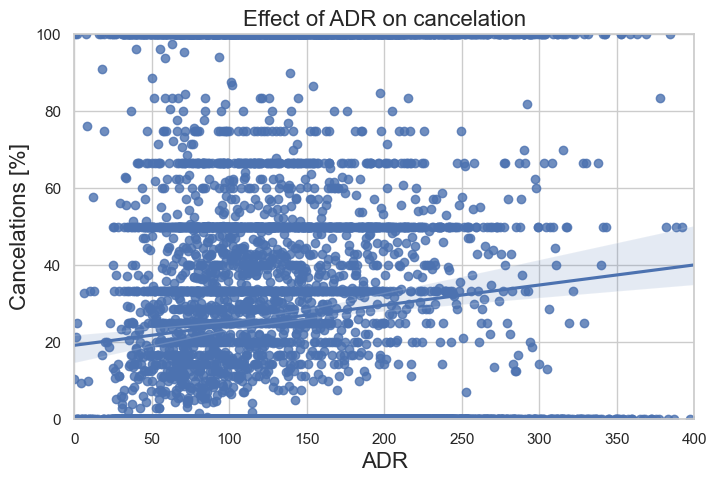

In [44]:
# group data for adr:
adr_cancel_data = full_data_cln.groupby("adr")["is_canceled"].describe()
#show figure:
plt.figure(figsize=(8, 5))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100)
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,400)
plt.ylim(0,100)
plt.show()

In [45]:
pd.DataFrame(full_data_cln.groupby("adr")["is_canceled"])

,0,1
0,-6.38,"14969 0 Name: is_canceled, dtype: int64"
1,0.00,0 0 1 0 125 0 167 ...
2,0.26,"35059 0 Name: is_canceled, dtype: int64"
3,0.50,"47427 1 Name: is_canceled, dtype: int64"
4,1.00,47466 1 47642 1 47661 1 82659 0 82...
...,...,...
8861,450.00,"13142 1 Name: is_canceled, dtype: int64"
8862,451.50,"103912 0 Name: is_canceled, dtype: int64"
8863,508.00,"15083 0 Name: is_canceled, dtype: int64"
8864,510.00,"111403 0 Name: is_canceled, dtype: int64"


### RF model without deposit type:

In [46]:
cat_features_non_dep = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features_non_dep = num_features + cat_features_non_dep
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]


# Bundle preprocessing for numerical and categorical features:
preprocessor_non_dep = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features_non_dep)])

# Define dataset:
X_non_dep = full_data.drop(["is_canceled"], axis=1)[features_non_dep]
# Define model
rf_model_non_dep = RandomForestClassifier(random_state=42) # basic model for this purpose

kfolds=4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor_non_dep),
                              ('model', rf_model_non_dep)])
cv_results = cross_val_score(model_pipe, 
                                 X_non_dep, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"RF model without deposit_type feature cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

RF model without deposit_type feature cross validation accuarcy score: 0.8653 +/- 0.0013 (std) min: 0.8631, max: 0.8663


In [47]:
# feat importance of original model:
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


In [48]:
# Check feature importance of new model:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X_non_dep,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features_non_dep))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first: 
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df_non_dep = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [ ]:
# feat importance of new model:
feat_imp_df_non_dep.head(10)

The new accuracy score of 0.8653 is almost identical to the one obtained with the deposit_type included (0.8664),
which placed significant wheight on this feature.
The new model compensated this by placing increased weight on lead_time, adr, total_of_special_requests and others.